项目要求：

在不使用sklearn的情况下，仅使用Numpy，为softmax回归实现带早停的批量梯度下降，将它用于分类任务，例如鸢尾花数据集

# 1、准备数据集（使用sklearn库中的IRIS数据集）

In [1]:
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)             # 这里转换成DataFrame的原因是可以对数据进行描述
X_pd = iris["data"]
y_pd = iris["target"]

In [2]:
# 简单看一下数据,因为y是分类数据，所以使用value_counts看一下他有几个类
X_pd.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [3]:
X_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [4]:
y_pd.value_counts()

target
0    50
1    50
2    50
Name: count, dtype: int64

# 2、分离数据集（shuffle + split）
!!! 注意：对于分类的数据集打乱，打乱前后  <span style="color: cyan">一定 !!! </span>  要确保X和标签y能对应上，否则数据会错误

最简单的办法：打乱前后去绘图，分类数据如果明显线性可分，则表示打乱一般没问题

In [5]:
import numpy as np
# 转成NumPy数组去操作
X = X_pd.to_numpy()
X = X[:,[2, 3]]             # 这里去鸢尾花的花瓣长度和宽度特征（petal length和petal width）
X = np.hstack([np.ones((X.shape[0], 1)), X])        # 加一列1，对应偏置项
y = y_pd.to_numpy()

In [6]:
np.random.seed(123)             # 设置随机数种子以复现结果
def shuffle_and_split(X, y, train_ration=0.8):
    """
    :param X: 要转换的数据，接收ndarray
    :param train_ration: 训练集的比例, 默认0.8
    :return: 返回两个NumPy数组，训练集和测试集（顺序不能反）
    """
    arr = np.arange(len(X))
    np.random.shuffle(arr)
    train_size = int(len(arr) * train_ration)
    train_indices, test_indices = arr[:train_size], arr[train_size:]
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

X_train, X_test, y_train, y_test = shuffle_and_split(X, y)

print(f"训练集数据的形状：{X_train.shape}")
print(f"训练集标签的形状：{y_train.shape}")
print(f"测试集数据的形状：{X_test.shape}")
print(f"测试集标签的形状：{y_test.shape}")
print(f"总样本数：{len(X)}, 样本的 80% 为 {len(X) * 0.8}")

训练集数据的形状：(120, 3)
训练集标签的形状：(120,)
测试集数据的形状：(30, 3)
测试集标签的形状：(30,)
总样本数：150, 样本的 80% 为 120.0


# 3、实现softmax的损失函数（交叉熵损失）
Softmax回归，也称多项式或多分类的Logistic回归

对于 $K$ 个分类来说，给定一个样本 $\mathbf{x}$, Softmax回归预测某个样本属于某个类别 $k$ 的概率定义为：
$$
\hat{p}_k = \text{softmax}(z) =  \sigma \bigl(\mathbf{\theta}_k^T \mathbf{x} \bigl) = \frac{\text{exp}(\mathbf{\theta}_k^T \mathbf{x})}{\sum_{j=1}^K\text{exp}(\mathbf{\theta}_j^T \mathbf{x})}
$$
其中，$\mathbf{\theta}_k$ 表示第 $k$个分类的权重

则，对于某个样本的预测值 $\hat{y}$,计算方法如下：
$$
\hat{y}
= \arg\max_{k}\ (\hat{p}_k)
= \arg\max_{k}\ \sigma \bigl(\mathbf{\theta}_k^T \mathbf{x} \bigl)
$$

对于 $m$个样本，$n$个特征，$K$ 个分类来说，Softmax 回归的交叉熵损失函数如下：
$$
J(\Theta)= -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K} y_{k}^{(i)} \,\log\!\left(\hat{p}_{k}^{(i)}\right)
$$

其中：$y_k^{(i)}$ 是属于第 $k$ 类的第 $i$ 个样本的真实值，等于 $1$ 或 $0$，具体取决于该实例是否属于该类，$\Theta$的形状为 $K \times m$

此时，交叉熵损失函数第 k 类的梯度向量为：
$$
g_k = \nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \left( \hat{p}_k^{(i)} - y_k^{(i)} \right) \mathbf{x}^{(i)}
$$


## $\ell_2$ 正则化后的交叉熵损失函数

加入 $\ell_2$ 正则化项，损失函数变为：
$$
J(\Theta)= -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K} y_{k}^{(i)} \,\log\!\left(\hat{p}_{k}^{(i)}\right) + \frac{\lambda}{2m} \sum_{i=1}^m \sum_{k=1}^K (\theta_k^{(i)})^2
$$

其中，$\lambda$ 是正则化系数

对于上述的损失函数，类 $k$ 的梯度为：

$$
\nabla_{\theta^{(k)}} J(\Theta) = \frac{1}{m} \sum_{i=1}^{m} \left( \hat{p}_k^{(i)} - y_k^{(i)} \right) \mathbf{x}^{(i)} + \frac{\lambda}{m} \theta^{(k)}
$$

此时，梯度下降的迭代公式为：
$$
\theta^{(k)} \;\leftarrow\; \theta^{(k)}-\alpha\Bigl[\frac{1}{m} \sum_{i=1}^{m} \left( \hat{p}_k^{(i)} - y_k^{(i)} \right) \mathbf{x}^{(i)} + \frac{\lambda}{m} \theta^{(k)}] = {\theta^{(k)}}
\Bigl(1 - \alpha \frac{\lambda}{m}\Bigr) - \alpha g_k
$$

In [7]:
def softmax(z):
    """
    :param z: z = x @ theta.T , 形状为 (m, k)
    :return:
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [8]:
# 实现损失函数
def compute_loss_func(X, y, theta, lambda_):
    """

    :param X: 样本，形状为(m, n)
    :param y: 分类标签，形状为(m,k), 独热编码
    :param theta: 样本的权重 (k, n)
    :param lambda_: 正则化系数
    :return: 损失值
    """
    m = X.shape[0]
    z = X @ theta.T
    p = softmax(z)      # m x k
    log_p = np.log(p)   # m x k
    losses = np.sum(y * log_p)
    total_theta = np.sum(np.concatenate(theta ** 2))

    cost = -losses / m + (lambda_ / (2 * m)) * total_theta
    return cost

# 4、计算梯度

In [9]:
# 计算梯度
def compute_gradient(X, y, theta):
    """

    :param X: 样本，形状为(m, n)
    :param y: 标签，形状为(m, k)
    :param theta: 样本的权重(k, n)
    :return: 损失函数的梯度
    """
    m = X.shape[0]
    z = X @ theta.T     # m x k
    p = softmax(z)      # m x k
    err = p - y         # m x k
    gk = err.T @ X / m     # k x n
    return gk

# 5、实现梯度下降算法

In [10]:
# 标签y要转成独热编码
def onehot_encoder(y):
    unique, indices = np.unique(y, return_inverse=True)
    n_rows, n_columns = len(y), len(unique)
    onehot_mat = np.zeros((n_rows, n_columns), dtype=np.int8)
    onehot_mat[np.arange(n_rows), unique[indices]] = 1
    return onehot_mat

In [11]:
def gradient_descent(X, y, theta_in, alpha, lambda_,
                     cost_function, compute_gradient, num_iters,
                     early_stopping=True, tol=1e-6, n_iter_no_change=10):
    """
    :param X: 样本，形状为(m, n)
    :param y: 标签，形状为(m, k)
    :param theta_in: 样本的权重，形状为 (k, n)
    :param alpha:  学习率
    :param lambda_: 正则化强度
    :param cost_function:  损失函数
    :param compute_gradient: 计算梯度函数:
    :param num_iters: 最大迭代次数
    :param early_stopping: 是否使用早停策略，默认False
    :param tol: 容差，早停策略，默认=1e-6
    :param n_iter_no_change: 进行几次迭代之后损失值不变化就停止
    :return: 损失值的列表，最终的权重
    """
    theta = theta_in
    m = X.shape[0]
    y_onehot = onehot_encoder(y)

    best_theta = theta.copy()
    best_cost = np.inf
    no_improve_count = 0

    J_history = []          # 记录损失值列表
    for i in range(num_iters):
        gk = compute_gradient(X, y_onehot, theta) + (lambda_ / m) * theta
        theta = theta - alpha * gk

        cost = cost_function(X, y_onehot, theta, lambda_)
        J_history.append(cost)

        if i % 10000 == 0:
            print(f"迭代次数：{i}, 损失值：{float(J_history[-1]):8.2f}")


        # 早停
        if early_stopping:
            if cost < best_cost - tol:
                best_cost = cost
                best_theta = theta.copy()
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count >= n_iter_no_change:
                    print(f"\nEarly stopping at iter {i} (best cost: {best_cost:.6f})")
                    break

    return J_history, best_theta if early_stopping else theta

In [12]:
# 初始化参数
k = 3
n = X.shape[1]
theta_init = np.random.randn(k, n)
alpha = 0.3
lambda_ = 0.002
num_iters = 10_0000

### 不使用早停策略

In [13]:
J_history, theta_mat = gradient_descent(X_train, y_train, theta_init, alpha, lambda_, compute_loss_func, compute_gradient, num_iters, early_stopping=False)

迭代次数：0, 损失值：    2.64
迭代次数：10000, 损失值：    0.09
迭代次数：20000, 损失值：    0.08
迭代次数：30000, 损失值：    0.07
迭代次数：40000, 损失值：    0.07
迭代次数：50000, 损失值：    0.07
迭代次数：60000, 损失值：    0.07
迭代次数：70000, 损失值：    0.07
迭代次数：80000, 损失值：    0.07
迭代次数：90000, 损失值：    0.07


### 使用早停策略（默认）

In [14]:
J_history, theta_mat = gradient_descent(X_train, y_train, theta_init, alpha, lambda_, compute_loss_func, compute_gradient, num_iters)

迭代次数：0, 损失值：    2.64
迭代次数：10000, 损失值：    0.09
迭代次数：20000, 损失值：    0.08
迭代次数：30000, 损失值：    0.07
迭代次数：40000, 损失值：    0.07

Early stopping at iter 41627 (best cost: 0.070592)


In [16]:
y_pred_proba = softmax(X_test @ theta_mat.T)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_one_hot = onehot_encoder(y_test)
accuracy_rate = np.mean(np.argmax(y_test_one_hot, axis=1) == y_pred)
print(f"模型预测的准确率为：{accuracy_rate * 100:.3f}%")

模型预测的准确率为：93.333%


# 6、绘制损失值和决策边界

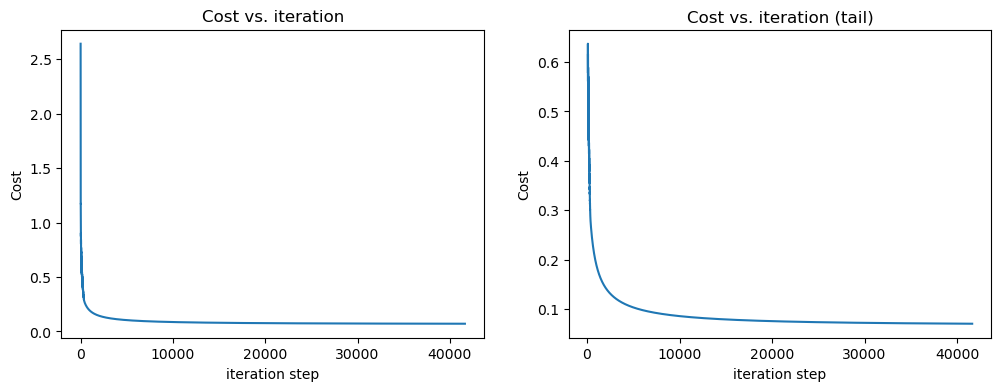

In [17]:
# plot cost vs 迭代次数
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(J_history)
ax2.plot(100 + np.arange(len(J_history[100:])), J_history[100:])
ax1.set_title("Cost vs. iteration")
ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')
ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')
ax2.set_xlabel('iteration step')
plt.show()

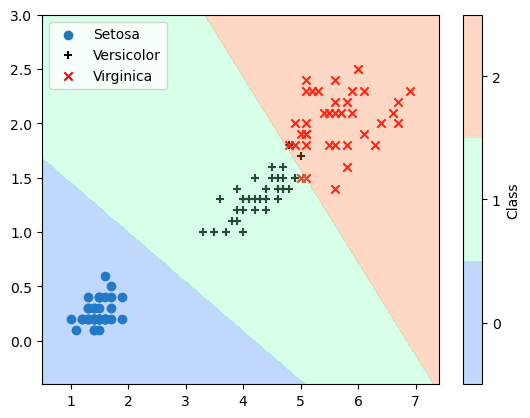

In [18]:
# 画决策边界
plt.scatter(X_train[y_train==0,1], X_train[y_train==0,2], marker='o', label="Setosa")
plt.scatter(X_train[y_train==1,1], X_train[y_train==1,2], marker='+', c="black", label="Versicolor")
plt.scatter(X_train[y_train==2,1], X_train[y_train==2,2], marker='x', c="r", label="Virginica")
plt.legend()

# 生成网格点
x1 = np.linspace(X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5, 500)
x2 = np.linspace(X_train[:, 2].min() - 0.5, X_train[:, 2].max() + 0.5, 500)
xx, yy = np.meshgrid(x1, x2)

# 对每个点进行预测
X_mesh_test = np.c_[np.ones((xx.ravel().shape[0])), xx.ravel(), yy.ravel()]
y_pred_proba = softmax(X_mesh_test @ theta_mat.T)
y_pred = np.argmax(y_pred_proba, axis=1)

Z = y_pred.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(4)-0.5, cmap='rainbow')
plt.colorbar(ticks=[0,1,2], label='Class')
plt.show()